导入相关库

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.calibration import calibration_curve
from scipy.stats import norm,skew,spearmanr, pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# 模型结果文件路径
model_files = {
    'GPR': 'data/gpr_results.csv',
    'XGBoost + Quantile': 'data/xgb_results.csv',
    'MLP + MC Dropout': 'data/mlp_results.csv'
}

Performance Evaluation

In [3]:
# 存储评估结果
metrics_dict = {
    'Model': [],
    'MAE': [],
    'RMSE': [],
    'R2': []
}

# 加载并计算指标
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    
    y_true = df['true']
    y_pred = df['pred']
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    metrics_dict['Model'].append(model_name)
    metrics_dict['MAE'].append(mae)
    metrics_dict['RMSE'].append(rmse)
    metrics_dict['R2'].append(r2)

# 输出评估表格
metrics_df = pd.DataFrame(metrics_dict)
print("模型预测性能指标对比：")
display(metrics_df.round(4))

模型预测性能指标对比：


,Model,MAE,RMSE,R2
0,GPR,0.1033,0.1824,0.9467
1,XGBoost + Quantile,0.1025,0.1837,0.9459
2,MLP + MC Dropout,0.1936,0.3006,0.9153


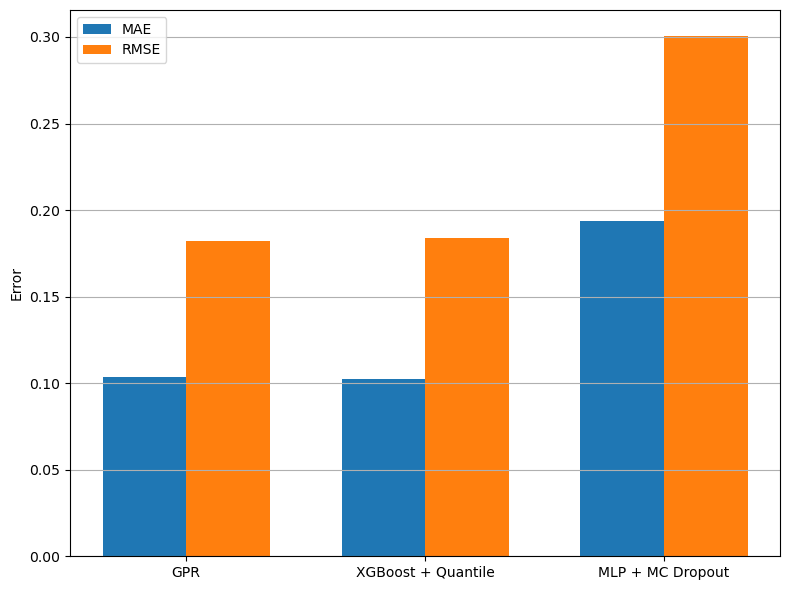

In [4]:
# 图1：模型误差柱状图（MAE / RMSE）
x = np.arange(len(metrics_df))
bar_width = 0.35

plt.figure(figsize=(8, 6))
plt.bar(x - bar_width/2, metrics_df['MAE'], bar_width, label='MAE')
plt.bar(x + bar_width/2, metrics_df['RMSE'], bar_width, label='RMSE')

plt.xticks(x, metrics_df['Model'])
plt.ylabel('Error')
# plt.title('Comparison of MAE and RMSE Across Models')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


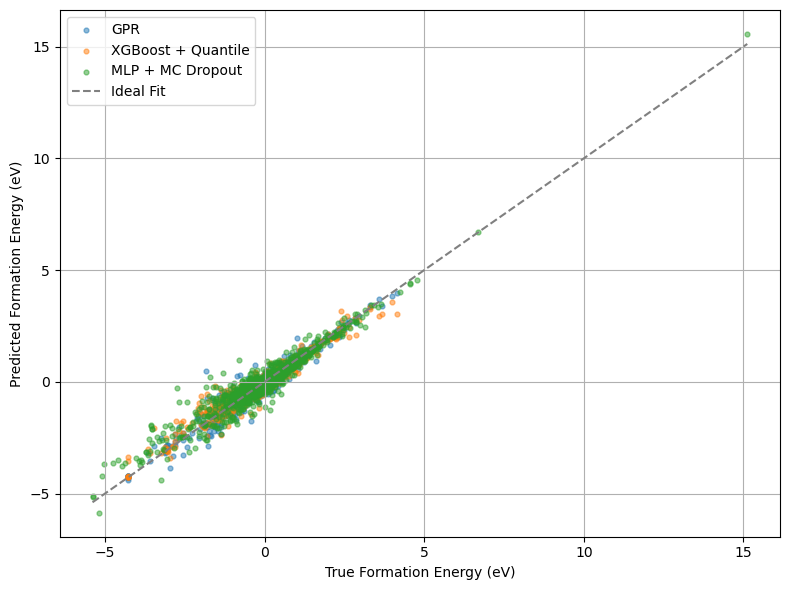

In [5]:
# 图2：真实值 vs 预测值散点图
plt.figure(figsize=(8, 6))
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    y_true = df['true']
    y_pred = df['pred']
    plt.scatter(y_true, y_pred, alpha=0.5, s=12, label=model_name)

plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--', color='gray', label='Ideal Fit')
plt.xlabel('True Formation Energy (eV)')
plt.ylabel('Predicted Formation Energy (eV)')
# plt.title('True vs Predicted: Model Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Interval Reliability

In [6]:
# 置信区间设置
confidence = 0.90
z_score = norm.ppf(0.5 + confidence / 2)

# 存储评估结果
interval_metrics = {
    'Model': [],
    'PICP (90%)': [],
    'MPIW (90%)': [],
    'Sharpness': []
}

# 计算指标
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    
    y_true = df['true']
    y_pred = df['pred']
    std = df['std']
    
    # 区间上下限
    lower = y_pred - z_score * std
    upper = y_pred + z_score * std
    
    # PICP: 有多少真实值落在区间中
    picp = ((y_true >= lower) & (y_true <= upper)).mean()
    
    # MPIW: 区间平均宽度
    mpiw = (upper - lower).mean()
    
    # Sharpness = 平均std
    sharpness = std.mean()

    interval_metrics['Model'].append(model_name)
    interval_metrics['PICP (90%)'].append(picp)
    interval_metrics['MPIW (90%)'].append(mpiw)
    interval_metrics['Sharpness'].append(sharpness)

# 输出表格
interval_df = pd.DataFrame(interval_metrics)
print("置信区间评估指标对比：")
display(interval_df.round(4))


置信区间评估指标对比：


,Model,PICP (90%),MPIW (90%),Sharpness
0,GPR,0.9105,0.5469,0.1663
1,XGBoost + Quantile,0.9010,0.4983,0.1515
2,MLP + MC Dropout,0.6310,0.4128,0.1255


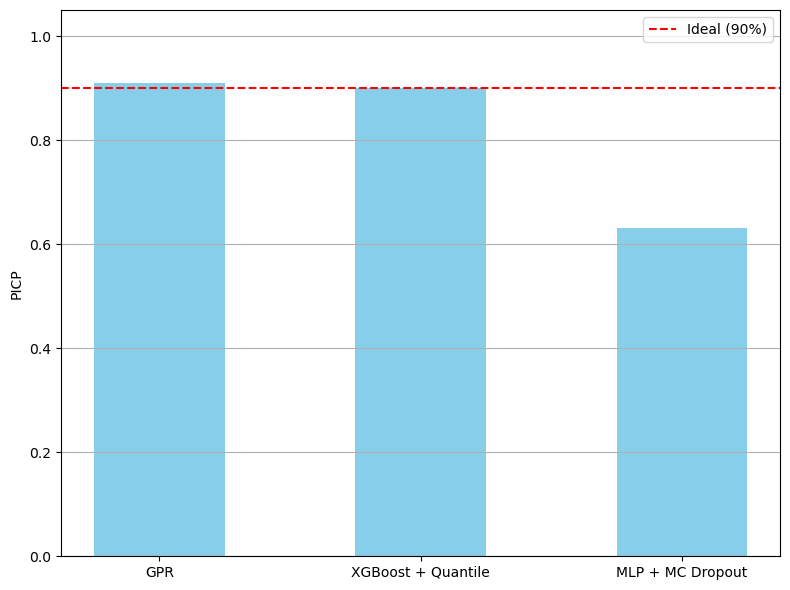

In [7]:
# 图3：PICP 柱状图（90% CI）
plt.figure(figsize=(8, 6))
x = np.arange(len(interval_df))

plt.bar(x, interval_df['PICP (90%)'], width=0.5, color='skyblue')
plt.axhline(y=confidence, color='red', linestyle='--', label='Ideal (90%)')

plt.xticks(x, interval_df['Model'])
plt.ylabel('PICP')
# plt.title('Prediction Interval Coverage Probability (90% CI)')
plt.ylim(0.0, 1.05)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


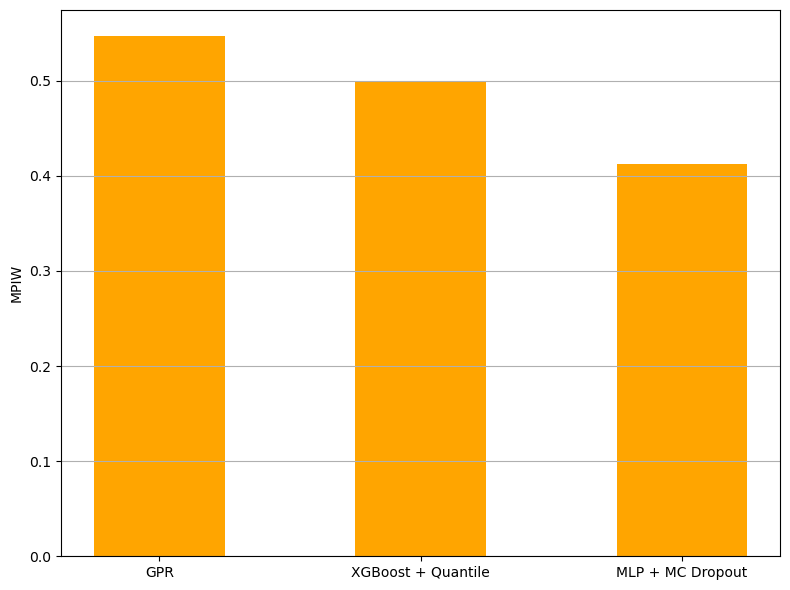

In [8]:
# 图4：MPIW 柱状图（90% CI）
plt.figure(figsize=(8, 6))
x = np.arange(len(interval_df))

plt.bar(x, interval_df['MPIW (90%)'], width=0.5, color='orange')

plt.xticks(x, interval_df['Model'])
plt.ylabel('MPIW')
# plt.title('Mean Prediction Interval Width (90% CI)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


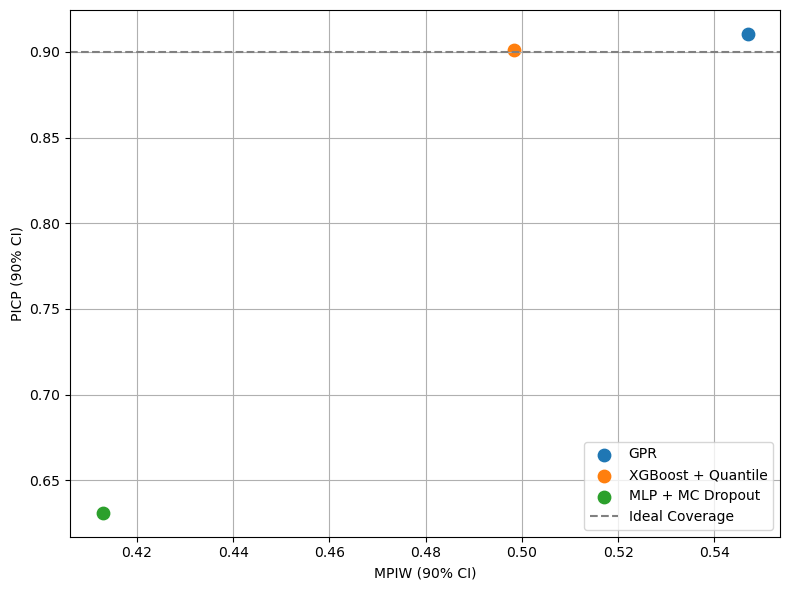

In [9]:
# 图5：PICP vs MPIW 散点图（90% CI）
plt.figure(figsize=(8, 6))

for i in range(len(interval_df)):
    model = interval_df['Model'][i]
    x_val = interval_df['MPIW (90%)'][i]
    y_val = interval_df['PICP (90%)'][i]
    plt.scatter(x_val, y_val, s=80, label=model)

plt.axhline(y=confidence, color='gray', linestyle='--', label='Ideal Coverage')
plt.xlabel('MPIW (90% CI)')
plt.ylabel('PICP (90% CI)')
# plt.title('PICP vs MPIW (90% CI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


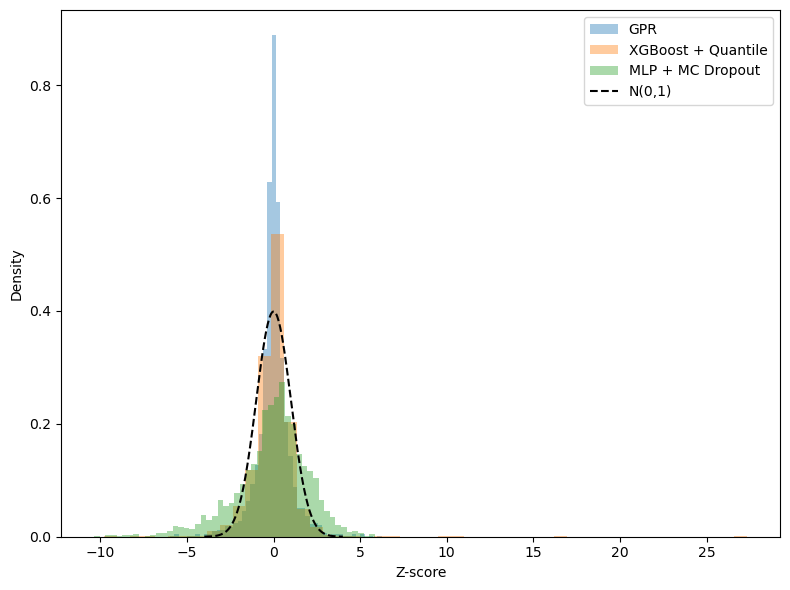

In [10]:
# 图6：Z-score 分布直方图（标准化残差）
plt.figure(figsize=(8, 6))

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    residual = df['true'] - df['pred']
    std = df['std']
    z = residual / std
    plt.hist(z, bins=50, alpha=0.4, density=True, label=model_name)

# 理想正态分布曲线
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'k--', label='N(0,1)')

plt.xlabel('Z-score')
plt.ylabel('Density')
# plt.title('Z-score Distribution (Standardized Residuals)')
plt.legend()
plt.tight_layout()
plt.show()


Distributional & Calibration Consistency

In [11]:
# 校准相关指标计算
calibration_metrics = {
    'Model': [],
    'ECE': [],
    'Z-score Skewness': [],
    'NLL': []
}

n_bins = 10  # 校准曲线分 bin 数

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    y_true = df['true']
    y_pred = df['pred']
    y_std = df['std']

    # z-score 分布
    z = (y_true - y_pred) / y_std

    # Calibration curve：不同置信度下的覆盖率
    conf_levels = np.linspace(0.05, 0.95, n_bins)
    observed_covers = []

    for c in conf_levels:
        z_val = norm.ppf(0.5 + c / 2)
        lower = y_pred - z_val * y_std
        upper = y_pred + z_val * y_std
        coverage = ((y_true >= lower) & (y_true <= upper)).mean()
        observed_covers.append(coverage)

    # ECE: Calibration Curve 与 y = x 理想线的平均绝对偏差
    ece = np.abs(np.array(observed_covers) - conf_levels).mean()

    # Z-score skewness
    skew_val = skew(z)

    # NLL: -log(p(y|mu, sigma))
    nll = -np.mean(norm.logpdf(y_true, loc=y_pred, scale=y_std))

    calibration_metrics['Model'].append(model_name)
    calibration_metrics['ECE'].append(ece)
    calibration_metrics['Z-score Skewness'].append(skew_val)
    calibration_metrics['NLL'].append(nll)

# 输出校准指标表格
calib_df = pd.DataFrame(calibration_metrics)
print("模型分布一致性与校准指标对比：")
display(calib_df.round(4))


模型分布一致性与校准指标对比：


,Model,ECE,Z-score Skewness,NLL
0,GPR,0.1406,-0.0694,-0.4805
1,XGBoost + Quantile,0.0733,5.3116,-0.4811
2,MLP + MC Dropout,0.1636,-0.8597,0.9428


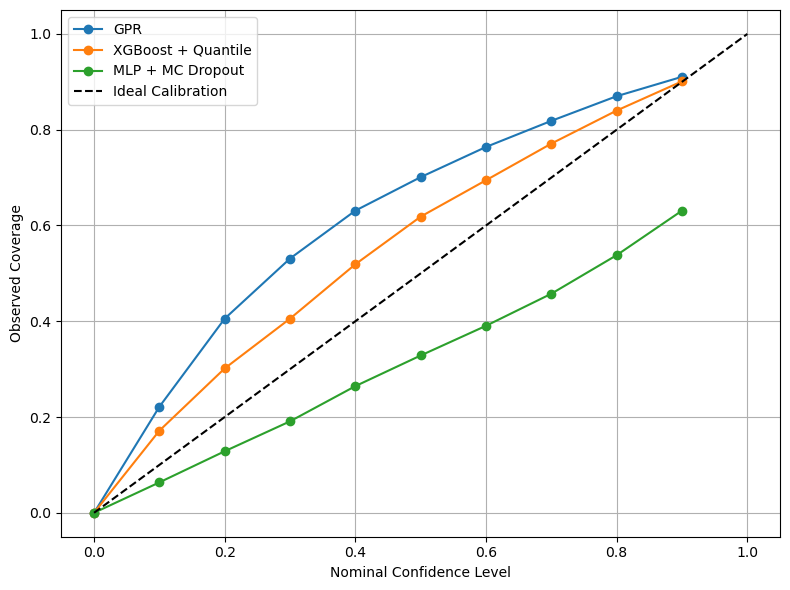

In [12]:
# 图7：Calibration Curve
plt.figure(figsize=(8, 6))
conf_levels = np.linspace(0.0, 0.9, n_bins)

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    y_true = df['true']
    y_pred = df['pred']
    y_std = df['std']
    observed = []

    for c in conf_levels:
        z_val = norm.ppf(0.5 + c / 2)
        lower = y_pred - z_val * y_std
        upper = y_pred + z_val * y_std
        coverage = ((y_true >= lower) & (y_true <= upper)).mean()
        observed.append(coverage)

    plt.plot(conf_levels, observed, marker='o', label=model_name)

# 理想参考线
plt.plot([0, 1], [0, 1], 'k--', label='Ideal Calibration')
plt.xlabel('Nominal Confidence Level')
plt.ylabel('Observed Coverage')
# plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


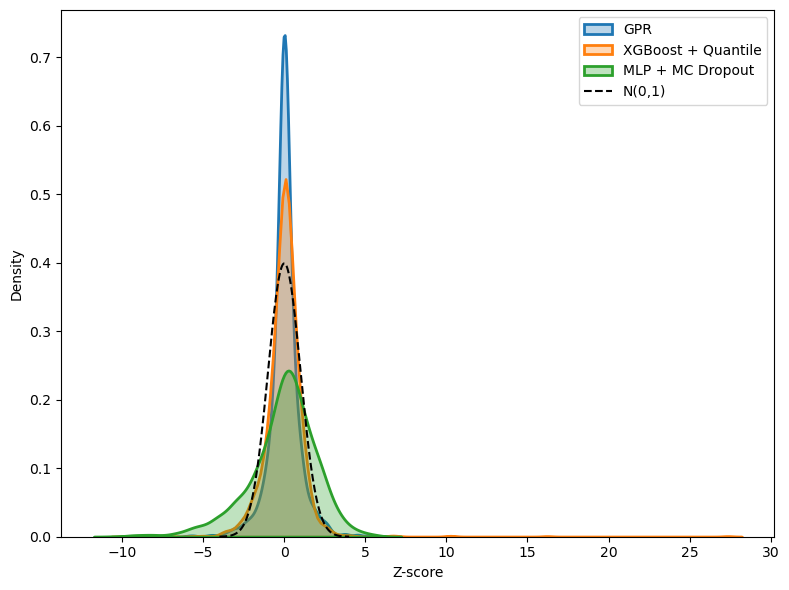

In [13]:
# 图8：Z-score KDE 分布 vs 标准正态
plt.figure(figsize=(8, 6))

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    z = (df['true'] - df['pred']) / df['std']
    sns.kdeplot(z, label=model_name, fill=True, alpha=0.3, linewidth=2)

# 添加标准正态 N(0,1)
x_vals = np.linspace(-4, 4, 200)
plt.plot(x_vals, norm.pdf(x_vals), 'k--', label='N(0,1)')

plt.xlabel('Z-score')
plt.ylabel('Density')
# plt.title('Z-score Distribution Compared with N(0,1)')
plt.legend()
plt.tight_layout()
plt.show()


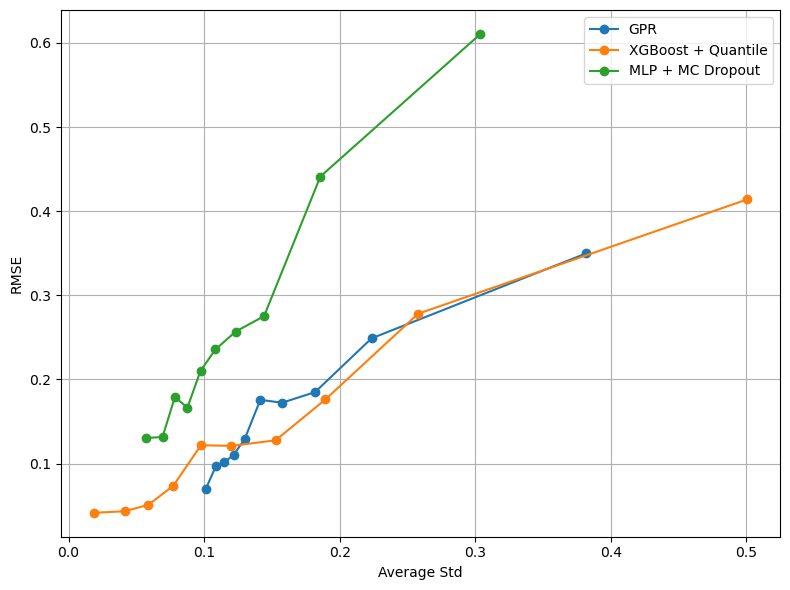

In [14]:
# 图9：不同 std 分段下的 RMSE 变化趋势
plt.figure(figsize=(8, 6))

n_bins = 10  # 可调节分段数
for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    df['bin'] = pd.qcut(df['std'], n_bins, duplicates='drop')
    bin_rmse = df.groupby('bin').apply(lambda g: mean_squared_error(g['true'], g['pred'], squared=False))
    bin_centers = df.groupby('bin')['std'].mean()

    plt.plot(bin_centers, bin_rmse, marker='o', label=model_name)

plt.xlabel('Average Std')
plt.ylabel('RMSE')
# plt.title('RMSE vs Predicted Std Bins')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


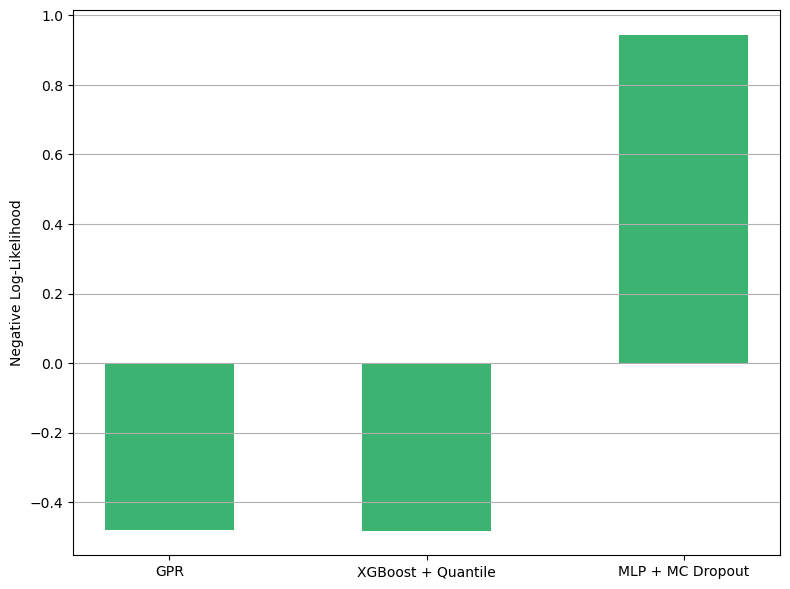

In [15]:
# 图10：NLL 柱状图
plt.figure(figsize=(8, 6))
x = np.arange(len(calib_df))

plt.bar(x, calib_df['NLL'], width=0.5, color='mediumseagreen')
plt.xticks(x, calib_df['Model'])
plt.ylabel('Negative Log-Likelihood')
# plt.title('Negative Log-Likelihood (NLL) Comparison')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Ranking Utility

In [16]:
ranking_metrics = {
    'Model': [],
    'Spearman ρ': [],
    'Pearson r': [],
    'AUSE': []
}

n_points = 100  # 用于 sparsification 曲线的分辨率

sparsification_curves = {}  # 储存每个模型的 sparsification 曲线（用于图12）

for model_name, file_path in model_files.items():
    df = pd.read_csv(file_path)
    df['error'] = np.abs(df['true'] - df['pred'])
    df = df.sort_values(by='std')  # std 由小到大排序

    # 计算 Spearman / Pearson
    rho, _ = spearmanr(df['std'], df['error'])
    r, _ = pearsonr(df['std'], df['error'])

    # Sparsification Curve: 逐步剔除最大 uncertainty 样本后的 MAE
    frac_retained = np.linspace(1.0, 0.05, n_points)
    spars_mae = []

    for frac in frac_retained:
        k = int(len(df) * frac)
        subset = df.iloc[:k]  # 保留低 uncertainty 的前 k 个样本
        mae = mean_absolute_error(subset['true'], subset['pred'])
        spars_mae.append(mae)

    # AUSE: 曲线下方面积
    ause = np.trapz(spars_mae, frac_retained)

    ranking_metrics['Model'].append(model_name)
    ranking_metrics['Spearman ρ'].append(rho)
    ranking_metrics['Pearson r'].append(r)
    ranking_metrics['AUSE'].append(ause)

    sparsification_curves[model_name] = (frac_retained, spars_mae)

# 输出指标表格
ranking_df = pd.DataFrame(ranking_metrics)
print("模型排序相关性与应用性指标对比：")
display(ranking_df.round(4))

模型排序相关性与应用性指标对比：


,Model,Spearman ρ,Pearson r,AUSE
0,GPR,0.3121,0.3145,-0.0656
1,XGBoost + Quantile,0.5871,0.4731,-0.0449
2,MLP + MC Dropout,0.3736,0.4326,-0.1200


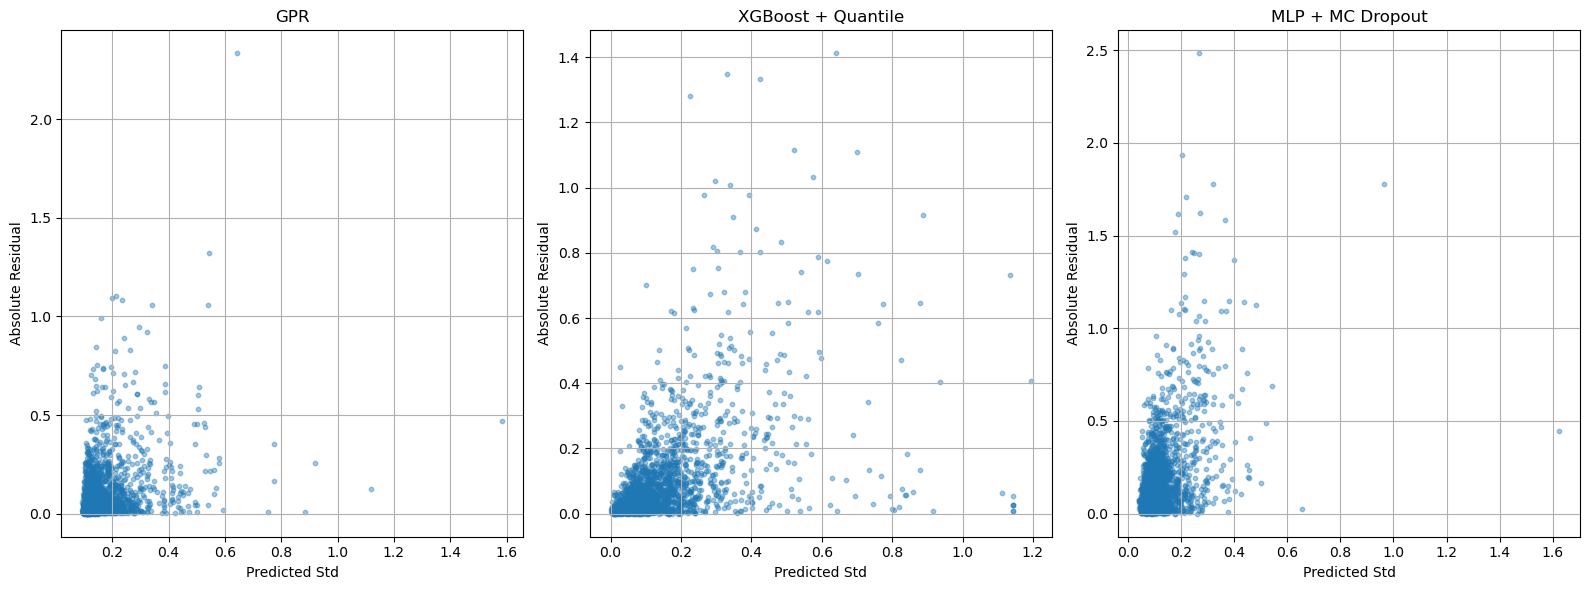

In [17]:
# 图11：std vs error 散点图（含 Spearman ρ）
plt.figure(figsize=(16, 6))

for idx, (model_name, file_path) in enumerate(model_files.items()):
    df = pd.read_csv(file_path)
    df['error'] = np.abs(df['true'] - df['pred'])
    rho, _ = spearmanr(df['std'], df['error'])

    plt.subplot(1, 3, idx + 1)
    plt.scatter(df['std'], df['error'], alpha=0.4, s=10)
    plt.xlabel('Predicted Std')
    plt.ylabel('Absolute Residual')
    plt.title(f'{model_name}')
    plt.grid(True)

plt.tight_layout()
plt.show()


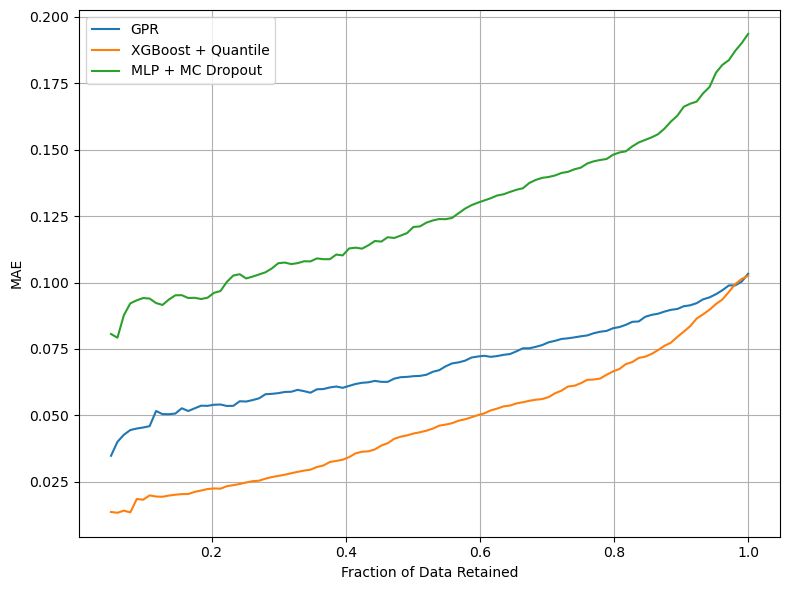

In [18]:
# 图12：Sparsification Curve
plt.figure(figsize=(8, 6))

for model_name, (x_vals, y_vals) in sparsification_curves.items():
    plt.plot(x_vals, y_vals, label=model_name)

plt.xlabel('Fraction of Data Retained')
plt.ylabel('MAE')
# plt.title('Sparsification Curve (Sorted by Predicted Std)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


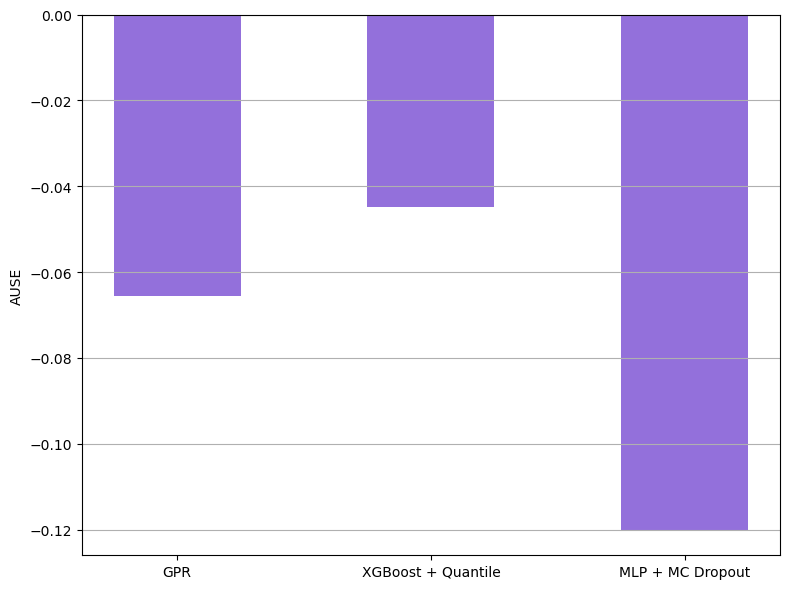

In [19]:
# 图13：AUSE 柱状图
plt.figure(figsize=(8, 6))
x = np.arange(len(ranking_df))

plt.bar(x, ranking_df['AUSE'], width=0.5, color='mediumpurple')
plt.xticks(x, ranking_df['Model'])
plt.ylabel('AUSE')
# plt.title('Area Under Sparsification Error (AUSE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
